# Interpretation 3: KAN Compiler

We have shown in many examples how to extract symbolic formulas from KANs. Now we want to consider the reverse task: compiling a symbolic formula into KANs. This might be needed for many reasons. One use case is that we have prior knowledge which is the approximate ground truth (empirical/constitutive laws etc.) and we want to build this knowledge into neural networks and only fine tune the network to real data.

saving model version 0.1


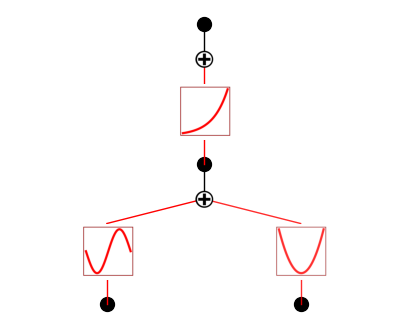

In [1]:
from kan.compiler import kanpiler
from sympy import *
from kan.utils import create_dataset
import torch

input_variables = x,y = symbols('x y')
expr = exp(sin(pi*x)+y**2)

model = kanpiler(input_variables, expr)

f = lambda x: torch.exp(torch.sin(torch.pi*x[:,0]) + x[:,1]**2)
dataset = create_dataset(f, n_var=2)
model.get_act(dataset)

model.plot()

if you want more complicated formulas, you can load in an equation in the Feynman dataset.

saving model version 0.1


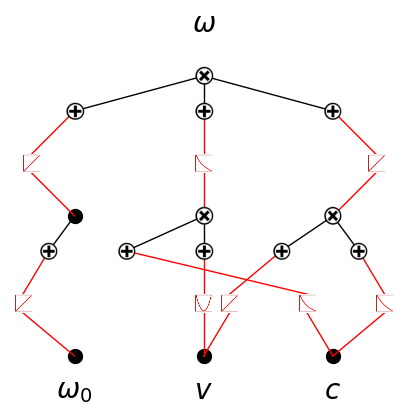

In [2]:
from kan.feynman import get_feynman_dataset
import matplotlib.pyplot as plt

problem_id = 36 # problem_id in 1-120
input_variables, expr, f, ranges = get_feynman_dataset(problem_id)
n_var = len(input_variables)
model = kanpiler(input_variables, expr)

dataset = create_dataset(f, n_var=n_var, ranges=ranges)
model.get_act(dataset)
#model.plot(in_vars=input_variables, out_vars=[expr], beta=10000, title='P{}'.format(problem_id))
model.plot(in_vars=input_variables, out_vars=[symbols('omega')], beta=10000)
#plt.savefig('./fig1.pdf', bbox_inches='tight', dpi=200)

We can check that the model indeed achieves zero loss (near machine precision) on the data

In [3]:
torch.mean((model(dataset['train_input'])-dataset['train_label'])**2)

tensor(1.5383e-15, grad_fn=<MeanBackward0>)

Assume we have a dataset for which the symbolic formula is only an approximate ground truth, we want to train on the real data to fine tune the model. The current model has the symbolic front turned on and the spline front turned off. So only the affine parameters in the symbolic equations are trainable. Depending on how much expressive power you would like, you may need:

* If you want to keep the symbolic functions, but just train the affine parameters, no need to do anything.
* If you want to the functions to be trainable, call model.perturb(). If you want only the currently active functions to be trainable while the currently dead functions to remain dead, use mode='minimal'. Otherwise if you want to allow the currently dead functions to be active, use mode = 'all' (by default).
* If you think the ground truth should be more complicated than the current network, you can expand it first using expand_width and/or expand_depth, and then use model.perturb().

In the following, we present the most complicated case where you want to expand the network first.

step 1: expand depth, add an extra linear function in the end

saving model version 0.2


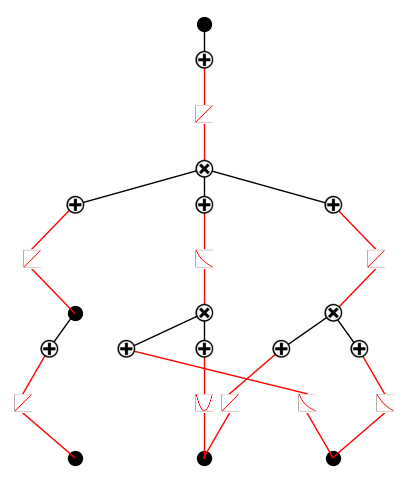

In [4]:
model.expand_depth()
model.get_act(dataset)
model.plot()

step 2: add two addition nodes in layer 1.

saving model version 0.3


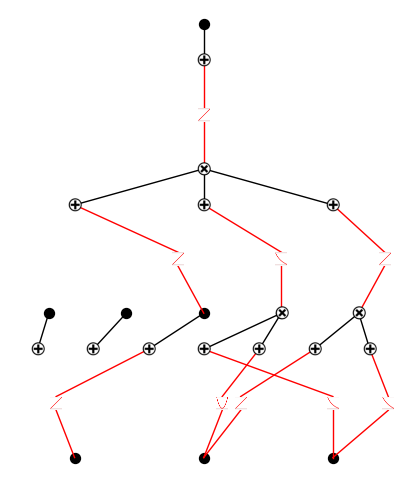

In [5]:
model.expand_width(1, 2)
model.get_act(dataset)
model.plot()

In [6]:
model.act_fun[2].coef.shape

torch.Size([1, 1, 8])

In [7]:
model.width

[[3, 0], [3, 2], [0, 1], [1, 0]]

step 3: add two multiplication nodes in layer 2, with arity 2 and 3.

saving model version 0.4


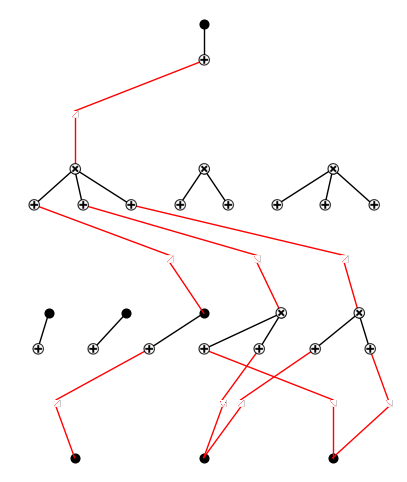

In [8]:
model.expand_width(2, 2, sum_bool=False, mult_arity=[2,3])
model.get_act(dataset)
model.plot()

step 4: now we perturb all edges (mode='minimal' only perturb the currently active edges, mode='all' perturbs all neurons).

saving model version 0.5


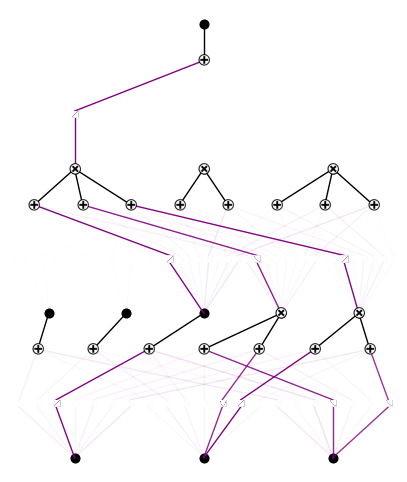

In [9]:
model.perturb(mag=0.1, mode='all')
model.get_act(dataset)
model.plot(metric='forward_n')
# purple means both symbolic front (red) and spline front (black) are active

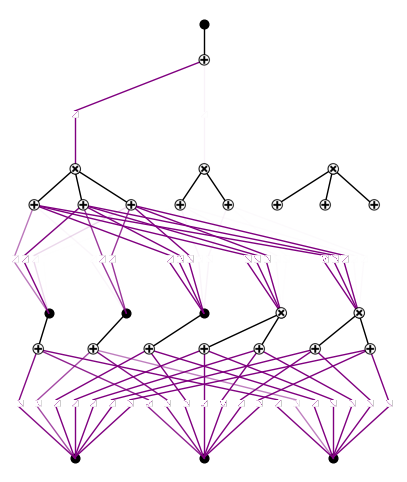

In [10]:
model.plot(beta=1000)